In [23]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [24]:
# Set the seed for reproducibility
seed_value = 0
np.random.seed(seed_value)

# Create the LunarLander environment
env = gym.make('LunarLander-v2')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


## Play with a "random" agent

Run the random agent

In [5]:
max_episodes = 100
scores = []
actions = range(env.action_space.n)
for i in range(1, max_episodes+1):
    state = env.reset()
    score = 0
    while True:
        action = np.random.choice(actions)
        # state, reward, done, info = env.step(action)
        state, reward, done, truncated , info = env.step(action)
        score += reward
        if done:
            if i % 20 == 0:
                print(f'Episode {i},  score: {score}')
            break

    scores.append(score)

/home/hostage/anaconda3/envs/AI_Gym/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 20,  score: -223.97369517969491
Episode 40,  score: -204.2468748964596
Episode 60,  score: -404.58078029957926
Episode 80,  score: -84.72776251130601
Episode 100,  score: -72.53709379833852


Results of the random agent

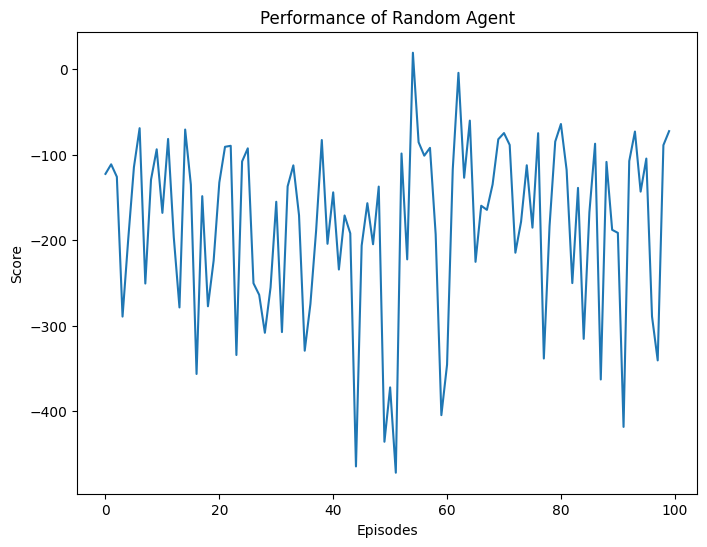

Average score of random agent over 100 episodes: -182.87


In [6]:
# Show random agent's performance
plt.figure(figsize=(8,6))
plt.plot(range(max_episodes), scores)
plt.title('Performance of Random Agent')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()

print('Average score of random agent over {} episodes: {:.2f}'.format(max_episodes, np.mean(scores)))

In [12]:
# Neural network model used for Q-learning
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)  

    # Implements the forward pass of the QNetwork.        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x        

In [11]:
# Replay buffer for experience replay in DQN.
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    # Adds an experience to the replay buffer
    def add(self, state, action, reward, next_state, done):
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
        
    # Samples a batch of experiences from the replay buffer                
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)  
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

## Implementing the DQN agent

In [7]:
class DQNAgent: 
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        # Initialize Q and Fixed Q networks
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.fixed_network = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())
        # Initiliase memory 
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0
        
    # Performs one step of learning using the provided experience
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)
    
    #   Updating the Q-network using a batch of experiences.
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        # Get the action with max Q value
        action_values = self.fixed_network(next_states).detach()
        max_action_values = action_values.max(1)[0].unsqueeze(1)
        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (GAMMA * max_action_values * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        # Calculate loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.update_fixed_network(self.q_network, self.fixed_network)
        
    #   Updates the fixed Q-network using the target Q-network.
    def update_fixed_network(self, q_network, fixed_network):
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)
        
    #   Selects an action using an epsilon-greedy policy.
    def act(self, state, eps=0.0):
        # Check if state is a tuple
        if isinstance(state, tuple):  
            state = state[0]  
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # set the network into evaluation mode 
        self.q_network.eval()
        # perform forward pass
        with torch.no_grad():
            action_values = self.q_network(state)
        # set the network back into training mode
        self.q_network.train()
        if np.random.rand() < eps:
            return np.random.randint(self.action_size)
        else:
            return torch.argmax(action_values, dim=1).item()
        
    # Saves the Q-network's state dict to the file
    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

## Implementing the DDQN agent

In [8]:
class DDQNAgent(DQNAgent):
    def __init__(self, state_size, action_size, seed):
        super(DDQNAgent, self).__init__(state_size, action_size, seed)
        self.q_network_target = QNetwork(state_size, action_size, seed).to(device)
        self.update_fixed_network(self.q_network, self.q_network_target)

    def act(self, state, eps=0.0):
        # Check if state is a tuple
        if isinstance(state, tuple):  
            state = state[0]
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network.eval()
        with torch.no_grad():
            action_values = self.q_network(state)
        self.q_network.train()

        if np.random.rand() < eps:
            return np.random.randint(self.action_size)
        else:
            return torch.argmax(action_values, dim=1).item()

    # Updates the Q-network using a batch of experiences for DDQNAgent.
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Use q_network to select actions for the next states
        next_actions = self.q_network(next_states).argmax(1).unsqueeze(1)

        # Use q_network_target to evaluate the Q values for the next_states and next_actions
        q_targets_next = self.q_network_target(next_states).gather(1, next_actions)

        Q_target = rewards + (GAMMA * q_targets_next * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update fixed weights
        self.update_fixed_network(self.q_network, self.q_network_target)

    def update_fixed_network(self, q_network, fixed_network):
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)

    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)


## Training the agents

Define hyperparameters and constants used in the learning process

In [15]:
BUFFER_SIZE = int(1e5) # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network

MAX_EPISODES = 2000  # Max number of episodes to play
MAX_STEPS = 1000     # Max steps allowed in a single episode/play
ENV_SOLVED = 100     # MAX score at which we consider environment to be solved
PRINT_EVERY = 25    # How often to print the progress

EPS_START = 1.0      # Default/starting value of eps
EPS_DECAY = 0.999    # Epsilon decay rate
EPS_MIN = 0.01       # Minimum epsilon 

In [13]:
# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f'State size: {state_size}, action size: {action_size}')

State size: 8, action size: 4


In [16]:
dqn_agent = DQNAgent(state_size, action_size, seed=0)

Train with DQN-Agent

In [14]:
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START
for episode in range(1, MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for _ in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, truncated , info = env.step(action)
        if isinstance(state, np.ndarray):
            dqn_agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break

        eps = max(eps * EPS_DECAY, EPS_MIN)
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            dqn_agent.checkpoint('solved_100_dqn.pth')
            break

    scores_window.append(score)
    scores.append(score)

end = time()
print(f'\nTook {end - start} seconds')

Environment solved in 2000 episodes, average score: 98.906
Took 803.0141456127167 seconds


In [15]:
dqn_agent.checkpoint('solved_100_dqn.pth')

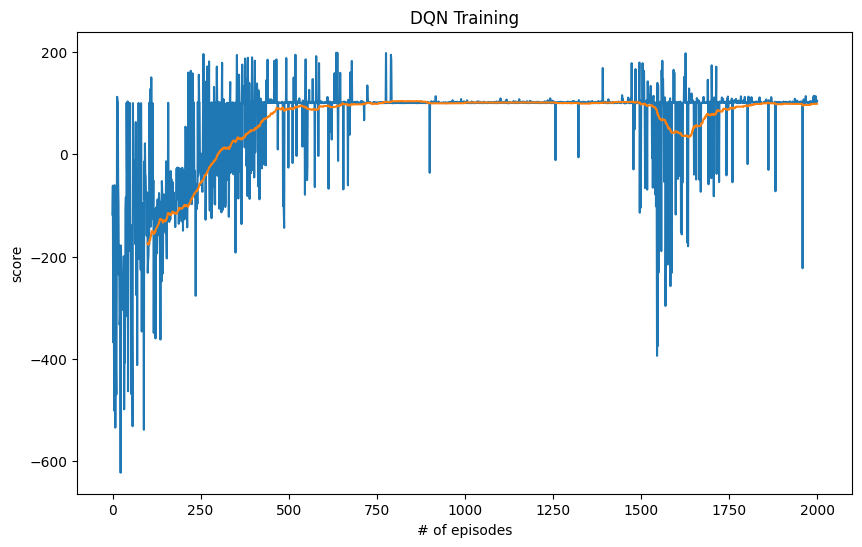

In [16]:
plt.figure(figsize=(10,6))
plt.plot(scores)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

Train with DDQN Agent

In [25]:
ddqn_agent = DDQNAgent(state_size, action_size, seed=0)

In [26]:
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START
for episode in range(1, MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for _ in range(MAX_STEPS):
        action = ddqn_agent.act(state, eps)
        next_state, reward, done, truncated , info = env.step(action)
        if isinstance(state, np.ndarray):
            ddqn_agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break

        eps = max(eps * EPS_DECAY, EPS_MIN)
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            ddqn_agent.checkpoint('solved_100_ddqn.pth')
            break

    scores_window.append(score)
    scores.append(score)

end = time()
print(f'\nTook {end - start} seconds')

 Progress 2000/2000, average score:108.32age score: 108.30
Took 2107.039666414261 seconds


In [27]:
ddqn_agent.checkpoint('solved_100_ddqn.pth')

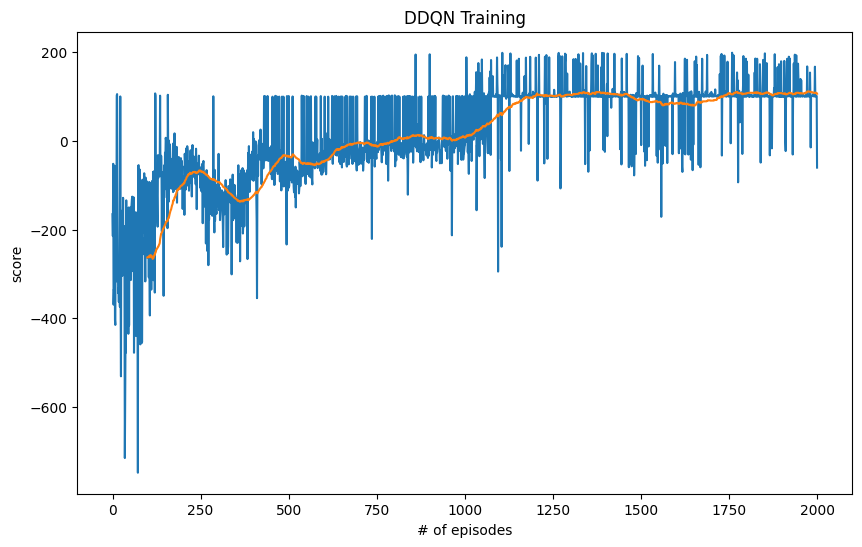

In [28]:
plt.figure(figsize=(10,6))
plt.plot(scores)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DDQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

## Testing the trained agents

### DQN Agent

In [18]:
dqn_agent.q_network.load_state_dict(torch.load('solved_100_dqn.pth'))

<All keys matched successfully>

In [19]:
for i in range(5):
    score = 0
    state = env.reset()
    while True:
        action = dqn_agent.act(state)
        next_state, reward, done, truncated , info = env.step(action)
        state = next_state        
        score += reward        
        if done:
            break
    print(f'episode: {i} scored {score}')
env.close()

episode: 0 scored 293.562273559045
episode: 1 scored 254.94627969097655
episode: 2 scored 90.47234886241267
episode: 3 scored 226.3994005394331
episode: 4 scored -231.41967877947002


### DDQN Agent

In [29]:
ddqn_agent.q_network.load_state_dict(torch.load('solved_100_ddqn.pth'))

<All keys matched successfully>

In [30]:
for i in range(5):
    score = 0
    state = env.reset()
    while True:
        action = ddqn_agent.act(state)
        next_state, reward, done, truncated , info = env.step(action)
        state = next_state        
        score += reward        
        if done:
            break
    print(f'episode: {i} scored {score}')
env.close()

episode: 0 scored 173.86968115505925
episode: 1 scored -7.151379801619939
episode: 2 scored 138.98743682626815
episode: 3 scored 219.19475749544864
episode: 4 scored 6.053606529269558
